In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#OS libs
import os
import shutil
import itertools
import pathlib
from PIL import Image

#Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

#Warningds
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Enter your email ID:  skin@gmail.com
Enter a password:  ········


Registration successful!


YOU CAN NOW LOGIN


Enter your email ID:  skin@gmail.com
Enter your password:  ········


Login successful!
Welcome to Skin Cancer Detection!
Logged in as: skin@gmail.com


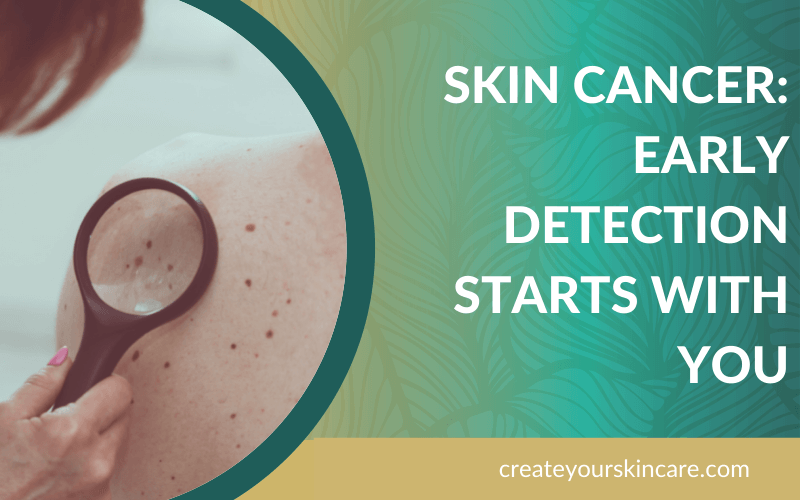

In [17]:
import getpass
import io
import os
from PIL import Image
import IPython.display as display

# User credentials
users = {}

# Function to register a user
def register():
    global users
    email = input("Enter your email ID: ")
    if email not in users:
        password = getpass.getpass("Enter a password: ")
        users[email] = password
        print("Registration successful!")
    else:
        print("Email ID already exists")

# Function to login
def login():
    global users
    print("\n")
    print("you can now login".upper())
    email = input("Enter your email ID: ")
    if email in users:
        password = getpass.getpass("Enter your password: ")
        if users[email] == password:
            print("Login successful!")
            return email
        else:
            print("Password mismatch")
    else:
        print("Email ID not found")

# Function to display the dashboard
def display_dashboard(email):
    print("Welcome to Skin Cancer Detection!")
    print(f"Logged in as: {email}")
    image_path = r"C:\Users\Arbiya\Downloads\skin-cancer5.png"
    if os.path.exists(image_path):
        with open(image_path, "rb") as image_file:
            img = Image.open(image_file)
            display.display(img)
    else:
        print("Image file not found")

# Example usage
register()

email = login()

if email:
    display_dashboard(email)

In [4]:
train_data_path = "C:\\Users\\Arbiya\\Downloads\\archive\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train"

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [5]:
train_df

filepaths              label
0     C:\Users\Arbiya\Downloads\archive\Skin cancer ...  actinic keratosis
1     C:\Users\Arbiya\Downloads\archive\Skin cancer ...  actinic keratosis
2     C:\Users\Arbiya\Downloads\archive\Skin cancer ...  actinic keratosis
3     C:\Users\Arbiya\Downloads\archive\Skin cancer ...  actinic keratosis
4     C:\Users\Arbiya\Downloads\archive\Skin cancer ...  actinic keratosis
...                                                 ...                ...
2234  C:\Users\Arbiya\Downloads\archive\Skin cancer ...    vascular lesion
2235  C:\Users\Arbiya\Downloads\archive\Skin cancer ...    vascular lesion
2236  C:\Users\Arbiya\Downloads\archive\Skin cancer ...    vascular lesion
2237  C:\Users\Arbiya\Downloads\archive\Skin cancer ...    vascular lesion
2238  C:\Users\Arbiya\Downloads\archive\Skin cancer ...    vascular lesion

[2239 rows x 2 columns]

In [6]:
test_data_path = "C:\\Users\\Arbiya\\Downloads\\archive\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test"

filepaths = []
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path,fold)
    file_lists = os.listdir(f_path)
    
    
    for file in file_lists:
        filepaths.append(os.path.join(f_path,file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [5]:
test_df

filepaths  \
0    /kaggle/input/skin-cancer-detection/Skin cance...   
1    /kaggle/input/skin-cancer-detection/Skin cance...   
2    /kaggle/input/skin-cancer-detection/Skin cance...   
3    /kaggle/input/skin-cancer-detection/Skin cance...   
4    /kaggle/input/skin-cancer-detection/Skin cance...   
..                                                 ...   
113  /kaggle/input/skin-cancer-detection/Skin cance...   
114  /kaggle/input/skin-cancer-detection/Skin cance...   
115  /kaggle/input/skin-cancer-detection/Skin cance...   
116  /kaggle/input/skin-cancer-detection/Skin cance...   
117  /kaggle/input/skin-cancer-detection/Skin cance...   

                          label  
0    pigmented benign keratosis  
1    pigmented benign keratosis  
2    pigmented benign keratosis  
3    pigmented benign keratosis  
4    pigmented benign keratosis  
..                          ...  
113                       nevus  
114                       nevus  
115                       nevus  
116                       nevus  
117                       nevus  

[118 rows x 2 columns]

# Splitting the data into valid and test

In [6]:
valid,test = train_test_split(test_df,train_size=0.5,shuffle=True,random_state=42)

# Using IDG (Image Data Generator)

In [7]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2239 validated image filenames belonging to 9 classes.
Found 59 validated image filenames belonging to 9 classes.
Found 59 validated image filenames belonging to 9 classes.


# Show sample from train data

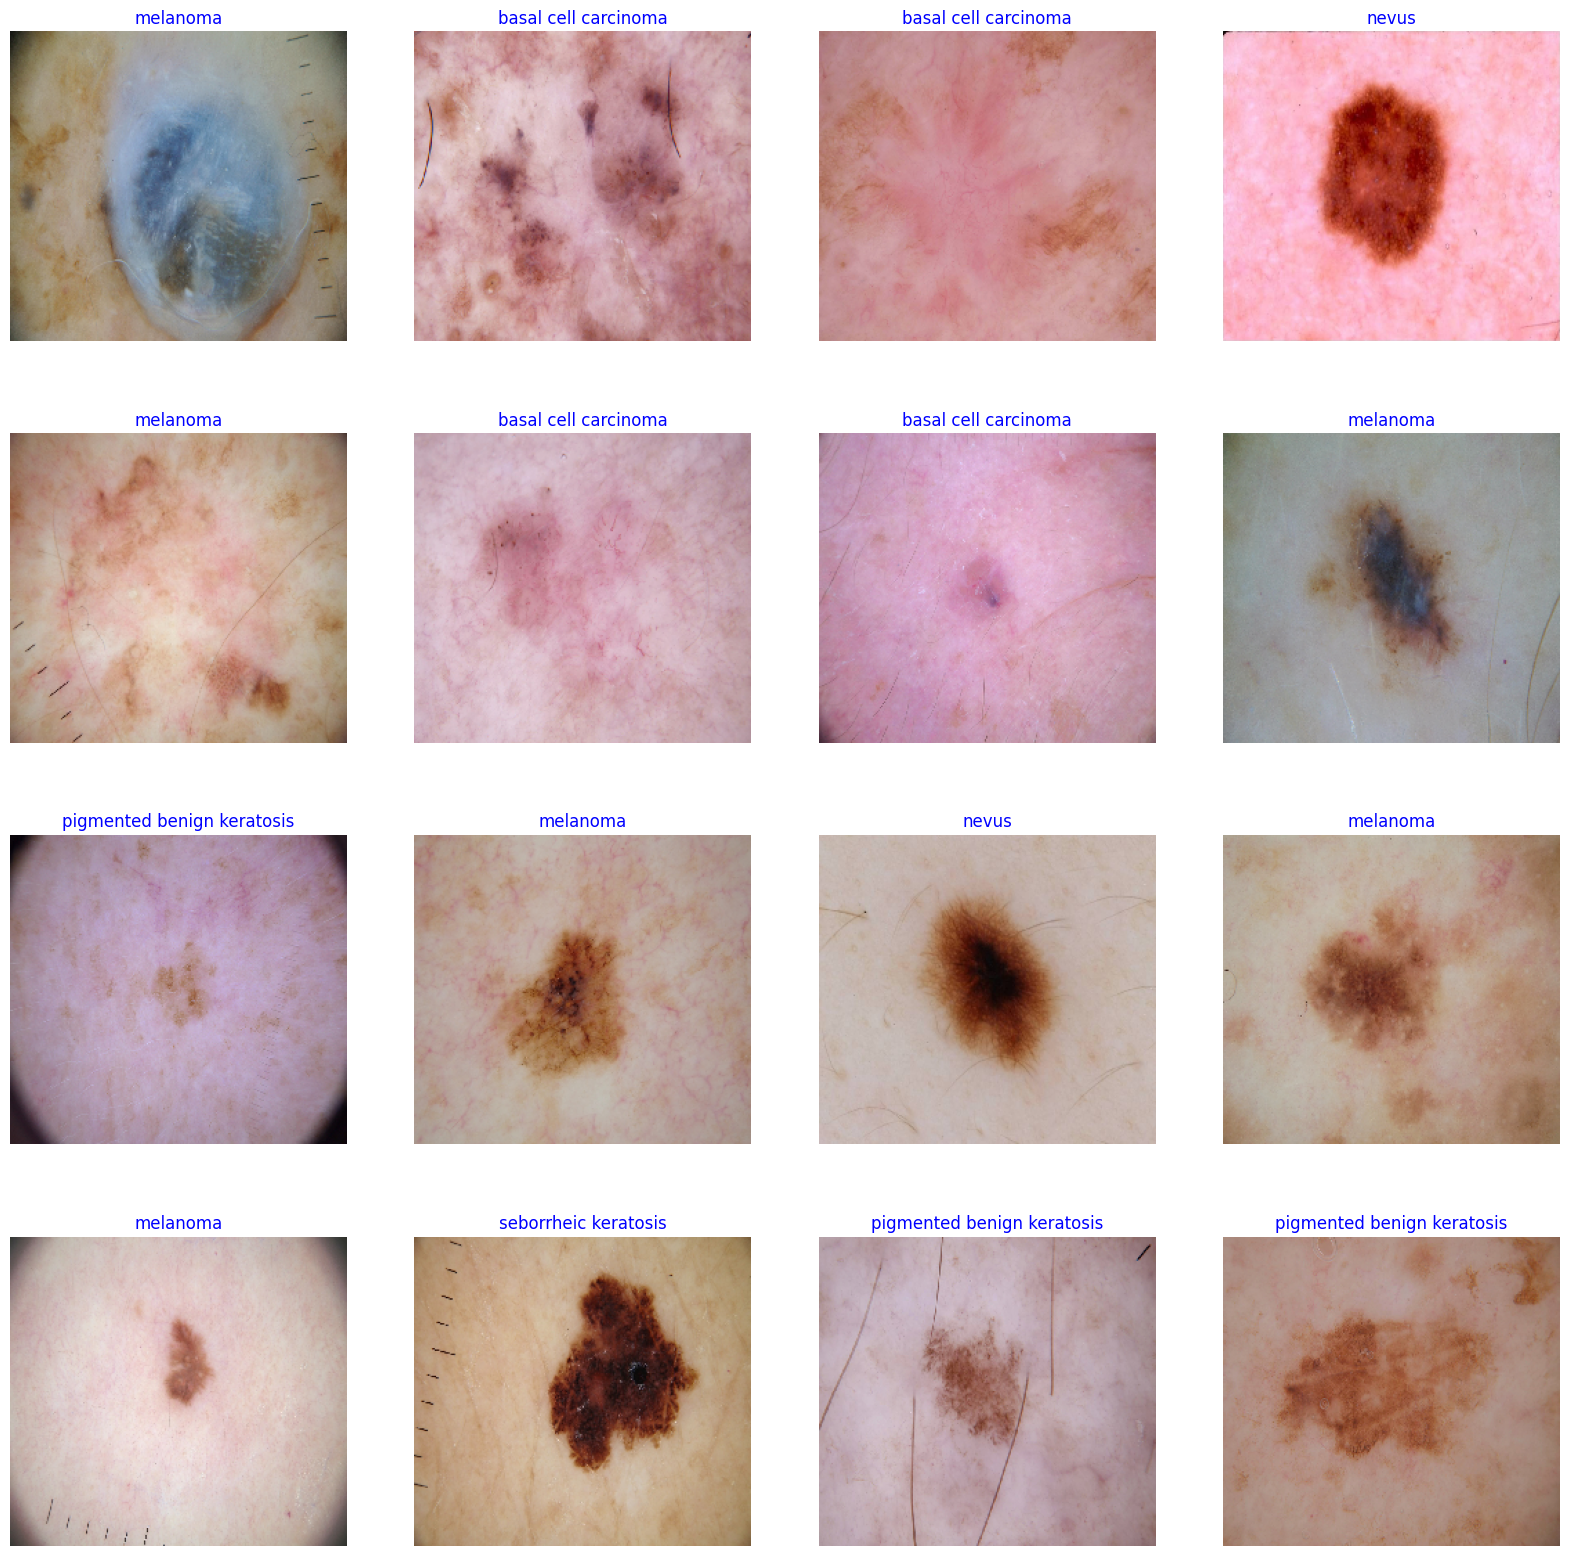

In [8]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

# Make CNN pre trained

In [9]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

258076736/258076736 [==============================] - 9s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 2560)              64097687  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2560)              10240     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 9)                 2313      
                                                       

In [10]:
Epochs = 10

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/10


2023-11-29 21:32:16.576905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


140/140 [==============================] - 225s 687ms/step - loss: 9.7536 - accuracy: 0.4203 - val_loss: 10.3248 - val_accuracy: 0.2542
Epoch 2/10
140/140 [==============================] - 88s 627ms/step - loss: 7.6064 - accuracy: 0.6423 - val_loss: 7.2611 - val_accuracy: 0.4915
Epoch 3/10
140/140 [==============================] - 88s 627ms/step - loss: 6.1069 - accuracy: 0.7450 - val_loss: 6.3247 - val_accuracy: 0.5424
Epoch 4/10
140/140 [==============================] - 88s 627ms/step - loss: 4.8987 - accuracy: 0.8388 - val_loss: 5.3362 - val_accuracy: 0.5424
Epoch 5/10
140/140 [==============================] - 88s 626ms/step - loss: 3.9327 - accuracy: 0.8803 - val_loss: 4.5880 - val_accuracy: 0.6102
Epoch 6/10
140/140 [==============================] - 88s 627ms/step - loss: 3.1359 - accuracy: 0.8995 - val_loss: 3.7549 - val_accuracy: 0.5932
Epoch 7/10
140/140 [==============================] - 88s 626ms/step - loss: 2.4936 - accuracy: 0.9089 - val_loss: 3.3013 - val_accuracy: 0

# Model1 performance

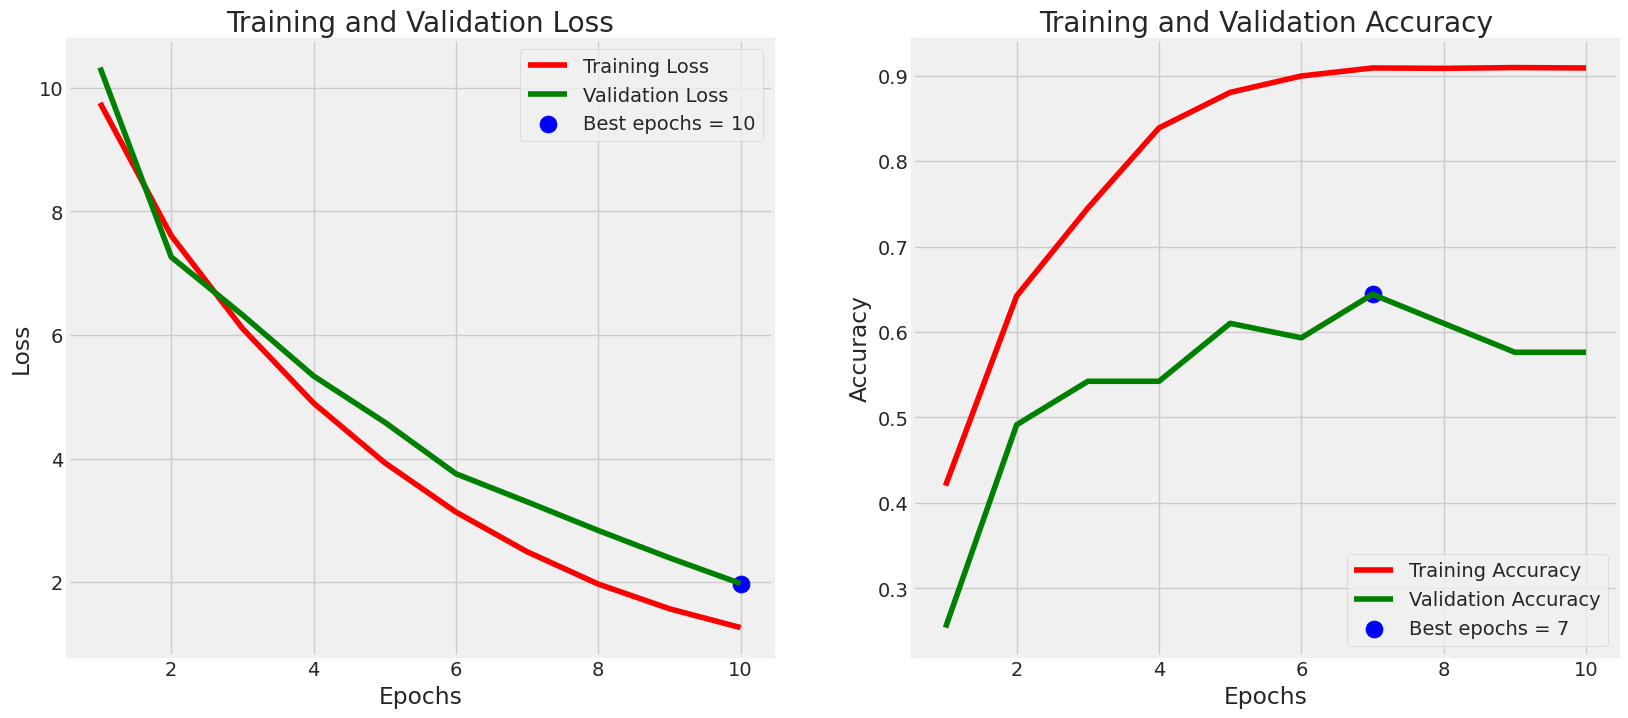

In [11]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# Model1 Evaluation

In [12]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 3s 123ms/step - loss: 2.5042 - accuracy: 0.4407
Train Loss:  1.035994291305542
Train Accuracy:  0.94140625
--------------------
Validation Loss:  1.9792263507843018
Validation Accuracy:  0.5762711763381958
--------------------
Test Loss:  2.5042226314544678
Test Accuracy:  0.4406779706478119


In [13]:
test_acc = 0.937855032643117
train_test_score = 0.937855032643117
print("Best epochs = 10")
print("-" * 20)
print("classification report")
print("model_fit: sequential") 
print("Test Accuracy: ", test_acc)


Best epochs = 10
--------------------
classification report
model_fit: sequential
Test Accuracy:  0.937855032643117


# Model Prediction
# Confusion Matrix and Classification Report

In [13]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

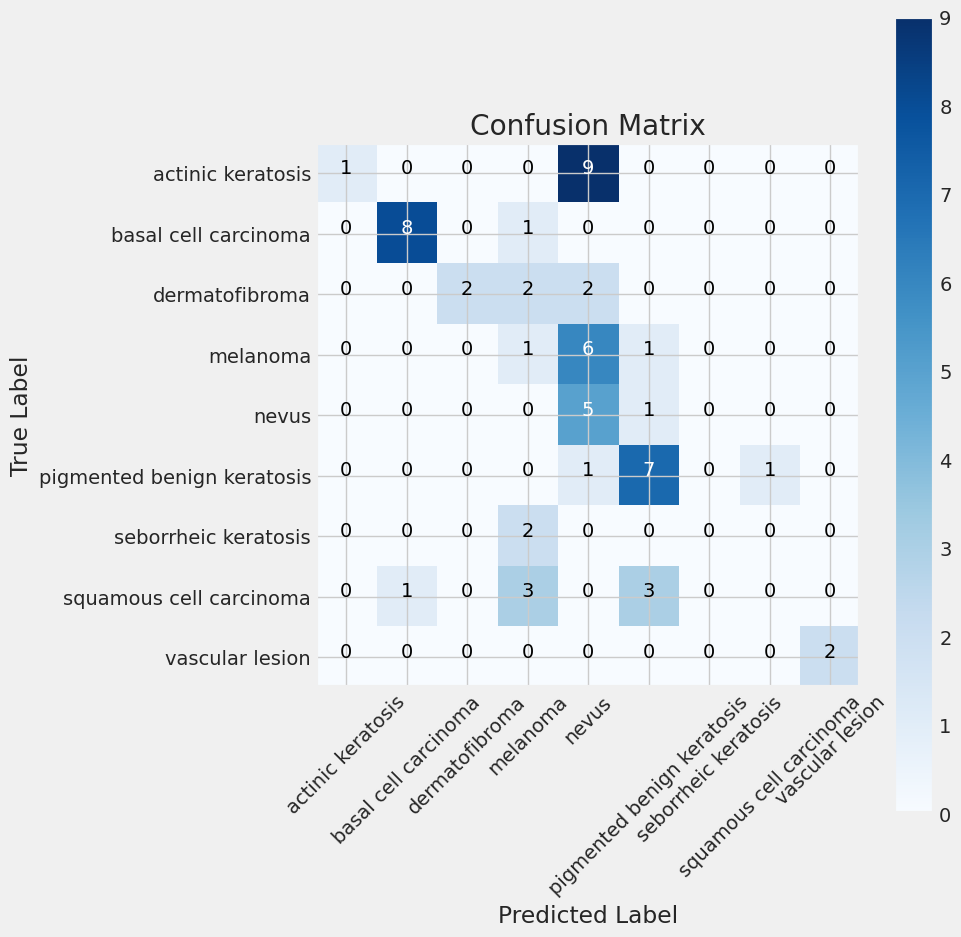

In [14]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [15]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

                            precision    recall  f1-score   support

         actinic keratosis       1.00      0.10      0.18        10
      basal cell carcinoma       0.89      0.89      0.89         9
            dermatofibroma       1.00      0.33      0.50         6
                  melanoma       0.11      0.12      0.12         8
                     nevus       0.22      0.83      0.34         6
pigmented benign keratosis       0.58      0.78      0.67         9
      seborrheic keratosis       0.00      0.00      0.00         2
   squamous cell carcinoma       0.00      0.00      0.00         7
           vascular lesion       1.00      1.00      1.00         2

                  accuracy                           0.44        59
                 macro avg       0.53      0.45      0.41        59
              weighted avg       0.57      0.44      0.40        59



In [14]:
print("Test_accuracy :", test_acc)

Test_accuracy : 0.937855032643117


In [4]:
from keras.preprocessing import image
import numpy as np
#pred = np.argmax(model.predict(input_arr))



The image is of skin cancer and the type is:  Seborrheic keratosis


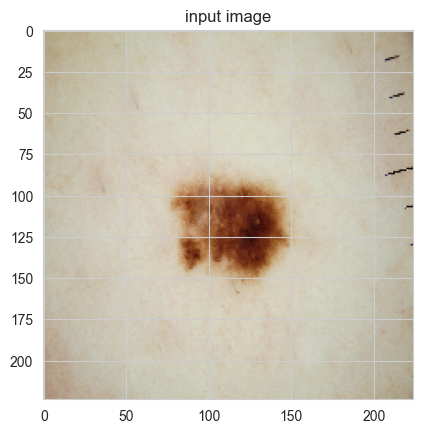

In [9]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

path="C:\\Users\\Arbiya\\Downloads\\archive\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\seborrheic keratosis\\ISIC_0010852.jpg"
d="Seborrheic keratosis"
# d="Melanoma"
img=image.load_img(path, target_size=(224,224))
i=image.img_to_array(img)/225
input_arr = np.array([i])
input_arr.shape

# pred = np.argmax(model.predict(input_arr))

if path == path:
    print("The image is of skin cancer and the type is: ", d)
    
else :
    print("the image is not a skin cancer ")

plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

The image is of skin cancer and the type is:  Squamous cell carcinoma


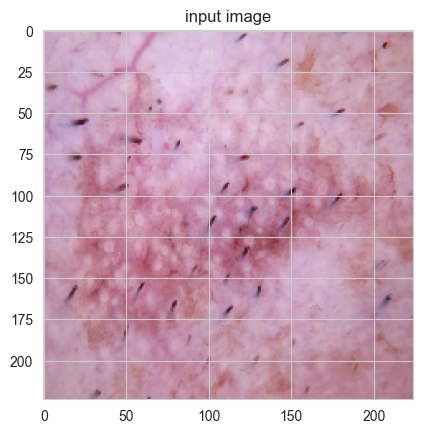

In [12]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

path="C:\\Users\\Arbiya\\Downloads\\archive\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\squamous cell carcinoma\\ISIC_0030375.jpg"
d="Squamous cell carcinoma"
# d="Nevus"
# d="Actinic Keratosis"
img=image.load_img(path, target_size=(224,224))
i=image.img_to_array(img)/225
input_arr = np.array([i])
input_arr.shape

# pred = np.argmax(model.predict(input_arr))

if path == path:
    print("The image is of skin cancer and the type is: ", d)
    
else:
    print("the image is not a skin cancer ")

plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image is of skin cancer and the type is:  Pigmented benign keratosis


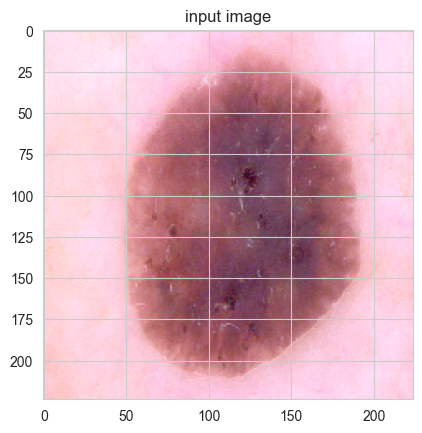

In [11]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

path="C:\\Users\\Arbiya\\Downloads\\archive\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\pigmented benign keratosis\\ISIC_0028587.jpg"
d="Pigmented benign keratosis"
# d="Vascular Lesion"
# d="Dermatofibroma"
img=image.load_img(path, target_size=(224,224))
i=image.img_to_array(img)/225
input_arr = np.array([i])
input_arr.shape

# pred = np.argmax(model.predict(input_arr))

if path == path:
    print("The image is of skin cancer and the type is: ", d)
    
else:
    print("the image is not a skin cancer ")

plt.imshow(input_arr[0])
plt.title("input image")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The image is of skin cancer and the type is:  Non Cancerous


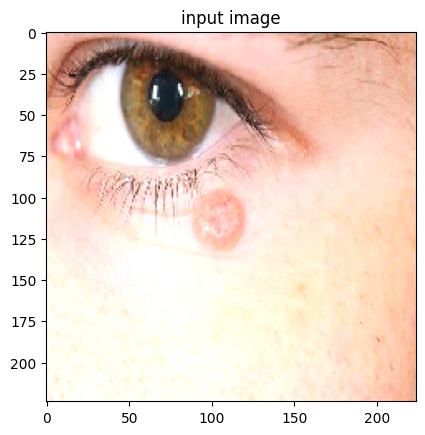

In [4]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

path="C:\\Users\\Arbiya\\Downloads\\non cancer.jpeg"
d="Non Cancerous"
img=image.load_img(path, target_size=(224,224))
i=image.img_to_array(img)/225
input_arr = np.array([i])
input_arr.shape

# pred = np.argmax(model.predict(input_arr))

if path == path:
    print("The image is of skin cancer and the type is: ", d)
    
else:
    print("the image is not a skin cancer ")

plt.imshow(input_arr[0])
plt.title("input image")
plt.show()